In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import os
%matplotlib inline

In [2]:
camcal_dir='./camera_cal/'
calimgs=os.listdir(camcal_dir)
#img=mpimg.imread(camcal_dir+calimgs[0])
#plt.imshow(img)

In [3]:
def grayscale(img, option=0):
    if option==0:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
    # Or use BGR2GRAY if you read an image with cv2.imread()
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

for calimg in calimgs:
    img=mpimg.imread(camcal_dir+calimg)
    gray = grayscale(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    else:
        print('corners not found for '+calimg)


corners not found for calibration1.jpg
corners not found for calibration4.jpg
corners not found for calibration5.jpg


In [5]:
def cal_undistort(img, objpoints, imgpoints):
    gray = grayscale(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray =grayscale(img)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray =grayscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray =grayscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    binary_output = np.zeros_like(h_channel)
    binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

In [7]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

g_l_center = -1
g_r_center = -1
def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    global g_l_center
    global g_r_center
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

    if g_l_center == -1 or (g_l_center > 0 and abs(g_l_center - l_center) < 100):
        g_l_center = l_center
    else:
        l_center = g_l_center
    
    if g_r_center == -1 or (g_r_center > 0 and abs(g_r_center - r_center) < 100):
        g_r_center = r_center
    else:
        r_center = g_r_center

        # Add what we found for the first layer
    window_centroids.append((image.shape[0]-(window_height/2), l_center,r_center))
    
    l_drift = 0
    r_drift = 0
    l_center_old = l_center
    r_center_old = r_center
    l_count=1
    r_count=1
    l_margin = margin
    r_margin = margin
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-l_margin,0))
        l_max_index = int(min(l_center+offset+l_margin,image.shape[1]))
        if max(conv_signal[l_min_index:l_max_index]) > 40000:
            l_center_old = l_center
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            drift = l_center - l_center_old
            l_drift = (l_drift*(l_count-1) + drift)/l_count
            l_count+=1
        else:
            l_center += l_drift
            l_margin += abs(l_drift)
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-r_margin,0))
        r_max_index = int(min(r_center+offset+r_margin,image.shape[1]))
        if max(conv_signal[r_min_index:r_max_index]) > 40000:
            r_center_old = r_center
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            drift = r_center - r_center_old
            r_drift = (r_drift*(r_count-1) + drift)/r_count
            r_count+=1
        else:
            r_center += r_drift
            r_margin += abs(r_drift)
        # Add what we found for that layer
        window_centroids.append((image.shape[0]-((level+0.5)*window_height), l_center,r_center))

    return window_centroids


In [8]:
def laneDetectPipeline(img):
    width=img.shape[1]
    height=img.shape[0]
    window_width = 50 
    window_height = 80
    margin = 100
    
    # Perspective transform parameters
    src=np.float32([[0, height], [530, 455], [750, 455], [width, height]])
    dst=np.float32([[0, height], [0, 0], [width, 0], [width, height]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    undistorted = cal_undistort(img, objpoints, imgpoints)
    warped = cv2.warpPerspective(undistorted, M, (width, height), flags=cv2.INTER_LINEAR)

    ksize = 5

    # Thresholding
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(50, 200))
    hsv = hsv_select(warped, (20, 40))
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) | (hsv == 1)] = 1

    # Lane detection
    combined*=255
    window_centroids = find_window_centroids(combined, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(combined)
        r_points = np.zeros_like(combined)

        # Go through each level and draw the windows    
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,combined,window_centroids[level][1],level)
            r_mask = window_mask(window_width,window_height,combined,window_centroids[level][2],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((combined,combined,combined)),np.uint8) # making the original road pixels 3 color channels
        plotimg = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    if len(window_centroids) == 0:
        print("no window centroids found")
        
    # Curve fitting
    window_centroids=np.array(window_centroids)
    ploty=window_centroids[:,0]
    leftx=window_centroids[:,1]
    rightx=window_centroids[:,2]
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Calculate deviation from center of the road
    cam_center=width/2
    lane_width_conversion=370/(rightx[0]-leftx[0])
    lane_center=(rightx[0]+leftx[0])/2

    # Calculate radius of the road curve
    sz=len(ploty)
    y=ploty[sz//2]
    f1=(2*left_fit[0]*y)+left_fit[1]
    f2=2*left_fit[0]
    Rcurve_left=((1+f1**2)**1.5)/np.abs(f2)

    f1=(2*right_fit[0]*y)+right_fit[1]
    f2=2*right_fit[0]
    Rcurve_right=((1+f1**2)**1.5)/np.abs(f2)
    
    Rcurve = (Rcurve_left + Rcurve_right)/2
    
    if Rcurve > 1000000.0:
        Rcurve = 1000000.0

    # Find poly to mark lanes
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    npts=np.int_(pts)
    cv2.fillPoly(warp_zero, npts, (0,255, 0))

    # Unwarp and mark lanes
    newwarp = cv2.warpPerspective(warp_zero, Minv, (width, height)) 
    wimage = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return wimage, int(Rcurve), int((lane_center-cam_center)*lane_width_conversion), combined, plotimg


In [9]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

def putLaneInfo(img, Rcurve, off_center):
    pilimg = Image.fromarray(np.uint8(img))
    draw = ImageDraw.Draw(pilimg)
    font = ImageFont.truetype("arial.ttf", 64)
    draw.text((50, 50),"Radius of Curvature = "+str(Rcurve),(255,255,255), font=font)
    off_str="right"
    if off_center < 0:
        off_str="left"
    draw.text((50, 120),"Vehicle is "+str(abs(off_center))+"cm "+str(off_str)+" of center",(255,255,255), font=font)    
    return np.asarray(pilimg)

In [10]:
def process_image(image):
    img, Rcurve, off_center, combined, plotimg = laneDetectPipeline(image)
    result = putLaneInfo(img, Rcurve, off_center)
    #result = img
    return result#, combined, plotimg

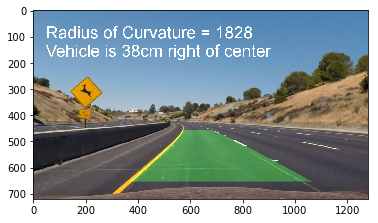

In [15]:
testimgs_dir='./test_images/'
testimgs=os.listdir(testimgs_dir)

img=mpimg.imread(testimgs_dir+testimgs[3])
#lni, combined, plotimg = process_image(img)
lni = process_image(img)
plt.imshow(lni)

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
marked_output = 'marked_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
marked_clip = clip1.fl_image(process_image)
%time marked_clip.write_videofile(marked_output, audio=False)

C:\Users\assingh\AppData\Local\Continuum\Miniconda3\envs\tensorflow\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file marked_video.mp4
----------------------------------------

Writing video into marked_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1210/1210 [17:34<00:00,  1.44it/s]


Done writing video in marked_video.mp4 !
Your video is ready !
Wall time: 17min 35s
